In [1]:
import pandas as pd
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import io
import requests

def read_url(url):
    content_raw = requests.get(url).content
    return pd.read_csv(io.StringIO(content_raw.decode('utf-8')))

PID = 'covid-spike'
tqdm.pandas()

# Cargar datos

## Defunciones totales

In [2]:
sql = """
SELECT Fecha,
       SUM(Defunciones) AS defunciones
FROM reportes_minsal.Defunciones_std
GROUP BY 1
"""
muertes = pd.read_gbq(sql, project_id=PID,use_bqstorage_api=True)
muertes['Fecha'] = pd.to_datetime(muertes['Fecha'])
muertes.sort_values(by=['Fecha'], inplace=True)
muertes = muertes.set_index('Fecha').resample('W').sum().reset_index()[1:]

Downloading: 100%|██████████| 3825/3825 [00:01<00:00, 2962.41rows/s]


## Muertes Covid

In [3]:
sql = """
SELECT Fecha,
       Total - IF(LAG(Total) OVER 
       (PARTITION BY Region ORDER BY Fecha) IS NULL, 0, LAG(Total) 
       OVER (PARTITION BY Region ORDER BY Fecha)) AS defunciones_covid
FROM reportes_minsal.FallecidosCumulativo_std
WHERE Region = 'Total'
"""
muertes_covid = pd.read_gbq(sql, project_id=PID,use_bqstorage_api=True)
muertes_covid['Fecha'] = pd.to_datetime(muertes_covid['Fecha'])
muertes_covid.sort_values(by=['Fecha'], inplace=True)
muertes_covid = muertes_covid.set_index('Fecha').resample('W').sum().reset_index()
muertes_covid['defunciones_covid_acumuladas'] = muertes_covid['defunciones_covid'].cumsum()

Downloading: 100%|██████████| 92/92 [00:01<00:00, 70.12rows/s] 


# Medir error
Se entrena hasta el 2018 y se predice todo el 2019

In [4]:
last_year_train_list = [2014, 2015, 2016, 2017, 2018]

median_ape_week = {}
mean_ape_week = {}

median_ape_month = {}
mean_ape_month = {}

for last_year_train in tqdm(last_year_train_list):
    cut_date = pd.to_datetime(f'{last_year_train+1}-1-1')

    time_series = (muertes
                  .rename(columns={'Fecha': 'ds', 'defunciones': 'y'}))
    time_series_cut = time_series[time_series.ds < cut_date]

    model = Prophet(seasonality_mode='multiplicative',
                    yearly_seasonality=True, 
                    weekly_seasonality=False, 
                    daily_seasonality=False,
                    interval_width=0.9)

    model.fit(time_series_cut)
    forecast = model.predict(time_series[['ds']])

    cols = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
    rename = {'yhat_lower': f'defunciones_predict_lower_{0.9}',
              'yhat_upper': f'defunciones_predict_upper_{0.9}',
              'yhat': 'defunciones_predict',
              'ds': 'Fecha'}
    forecast = forecast[cols].rename(columns=rename)
    forecast = pd.merge(muertes, forecast, on=['Fecha'])

    res_week = (forecast.Fecha >= cut_date) & (forecast.Fecha <= pd.to_datetime(f'{last_year_train+1}-12-31'))
    forecast['ape'] = forecast.eval('100 * abs(defunciones_predict - defunciones)/defunciones')
    mean_ape_week[last_year_train] = round(forecast.loc[res_week, 'ape'].mean(), 2)
    median_ape_week[last_year_train] = round(forecast.loc[res_week, 'ape'].median(), 2)
    
    forecast_month = forecast.set_index('Fecha').resample('M').sum().reset_index()
    res_month = (forecast_month.Fecha >= cut_date) & (forecast_month.Fecha <= pd.to_datetime(f'{last_year_train+1}-12-31'))
    forecast_month['ape'] = forecast_month.eval('100 * abs(defunciones_predict - defunciones)/defunciones')
    mean_ape_month[last_year_train] = round(forecast_month.loc[res_month, 'ape'].mean(), 2)
    median_ape_month[last_year_train] = round(forecast_month.loc[res_month, 'ape'].median(), 2)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
pd.concat([pd.Series(mean_ape_week).to_frame('mean_ape'), pd.Series(median_ape_week).to_frame('median_ape')], axis=1)

,mean_ape,median_ape
2014,4.23,3.40
2015,3.58,2.87
2016,3.85,3.05
2017,4.14,3.12
2018,3.55,2.36


In [6]:
pd.concat([pd.Series(mean_ape_month).to_frame('mean_ape'), pd.Series(median_ape_month).to_frame('median_ape')], axis=1)

,mean_ape,median_ape
2014,1.85,1.54
2015,2.28,2.12
2016,2.32,1.24
2017,2.51,1.31
2018,2.14,1.71


# Modelamiento

Entrenamos un modelo de prophet con datos de muertes por región hasta el 1 de marzo del 2020

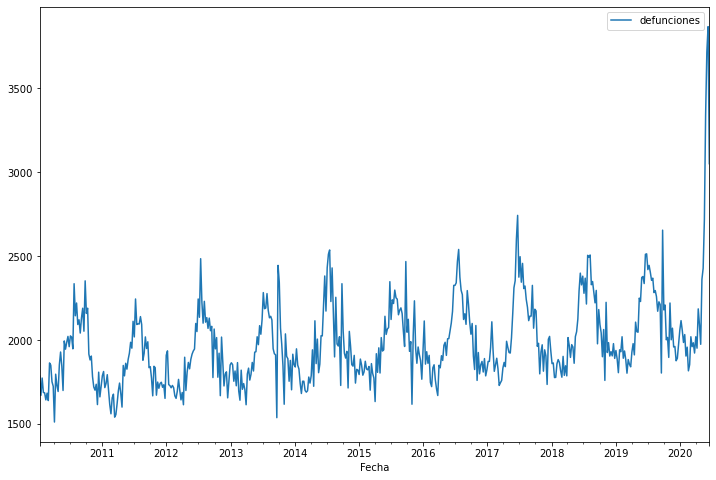

In [7]:
muertes.set_index('Fecha').plot(figsize=(12, 8))

In [8]:
cut_date = pd.to_datetime('2020-3-1')
confidence_list = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]


time_series = (muertes
              .rename(columns={'Fecha': 'ds', 'defunciones': 'y'}))
time_series_cut = time_series[time_series.ds < cut_date]

forecast_list = []
for confidence in confidence_list:
    model = Prophet(seasonality_mode='multiplicative',
                    yearly_seasonality=True, 
                    weekly_seasonality=False, 
                    daily_seasonality=False,
                    interval_width=confidence)

    model.fit(time_series_cut)
    forecast = model.predict(time_series[['ds']])

    cols = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
    rename = {'yhat_lower': f'defunciones_predict_lower_{confidence}',
              'yhat_upper': f'defunciones_predict_upper_{confidence}',
              'yhat': 'defunciones_predict',
              'ds': 'Fecha'}
    forecast = forecast[cols].rename(columns=rename)
    forecast_list += [forecast]

In [9]:
forecast = pd.concat(forecast_list, axis=1).T.drop_duplicates().T
forecast = pd.merge(muertes, forecast, on=['Fecha'])
cols = [c for c in forecast.columns if c != 'Fecha']
forecast[cols] = forecast[cols].astype(int)

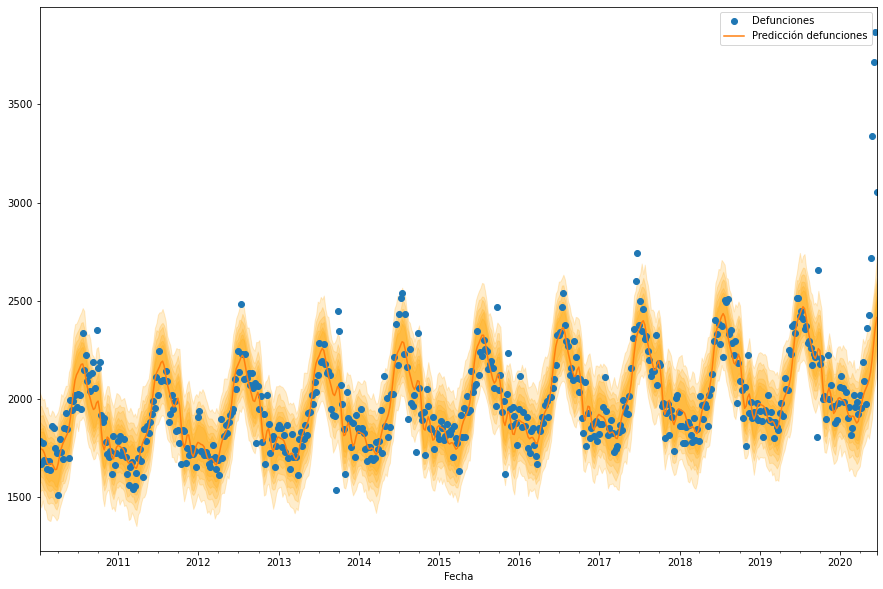

In [10]:
fecha_from_plot = pd.to_datetime('2010-1-1')


df_res = forecast[forecast.Fecha >= fecha_from_plot].set_index('Fecha')

ax = (df_res
      .defunciones.plot(figsize=(15, 10), label='Defunciones', style='o'))

(df_res
 .defunciones_predict.plot(ax=ax, style='-', label='Predicción defunciones'))

for confidence in confidence_list:
    ax.fill_between(df_res.index, 
                 df_res[f'defunciones_predict_lower_{confidence}'], 
                 df_res[f'defunciones_predict_upper_{confidence}'], 
                 color='orange',
                 alpha=0.2,
                 label=None)

ax.legend()

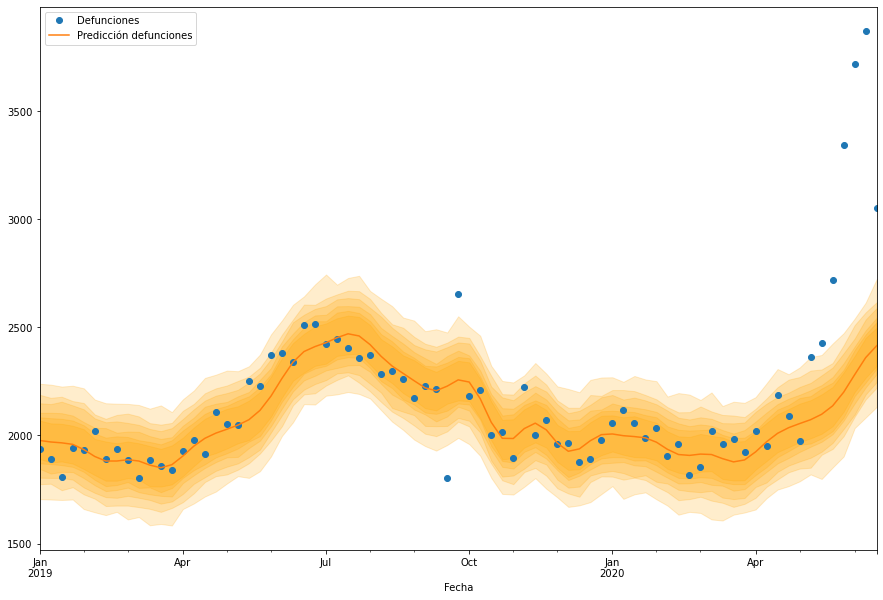

In [11]:
fecha_from_plot = pd.to_datetime('2019-1-1')

df_res = forecast[forecast.Fecha >= fecha_from_plot].set_index('Fecha')

ax = (df_res
      .defunciones.plot(figsize=(15, 10), label='Defunciones', style='o'))

(df_res
 .defunciones_predict.plot(ax=ax, style='-', label='Predicción defunciones'))

for confidence in confidence_list:
    ax.fill_between(df_res.index, 
                 df_res[f'defunciones_predict_lower_{confidence}'], 
                 df_res[f'defunciones_predict_upper_{confidence}'], 
                 color='orange',
                 alpha=0.2,
                 label=None)

ax.legend()

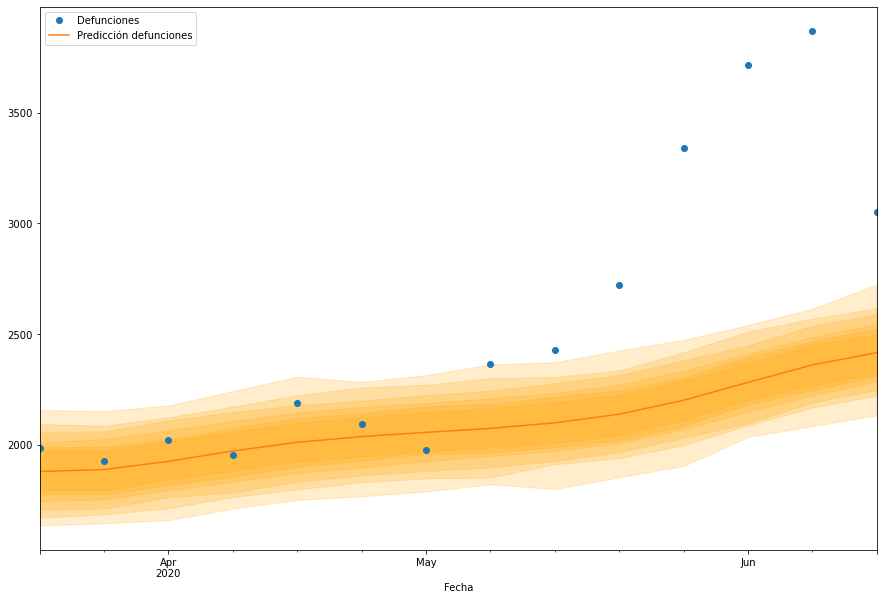

In [12]:
fecha_from_plot = pd.to_datetime('2020-3-22')

df_res = forecast[forecast.Fecha >= fecha_from_plot].set_index('Fecha')

ax = (df_res
      .defunciones.plot(figsize=(15, 10), label='Defunciones', style='o'))

(df_res
 .defunciones_predict.plot(ax=ax, style='-', label='Predicción defunciones'))

for confidence in confidence_list:
    ax.fill_between(df_res.index, 
                 df_res[f'defunciones_predict_lower_{confidence}'], 
                 df_res[f'defunciones_predict_upper_{confidence}'], 
                 color='orange',
                 alpha=0.2, label=None)

ax.legend()

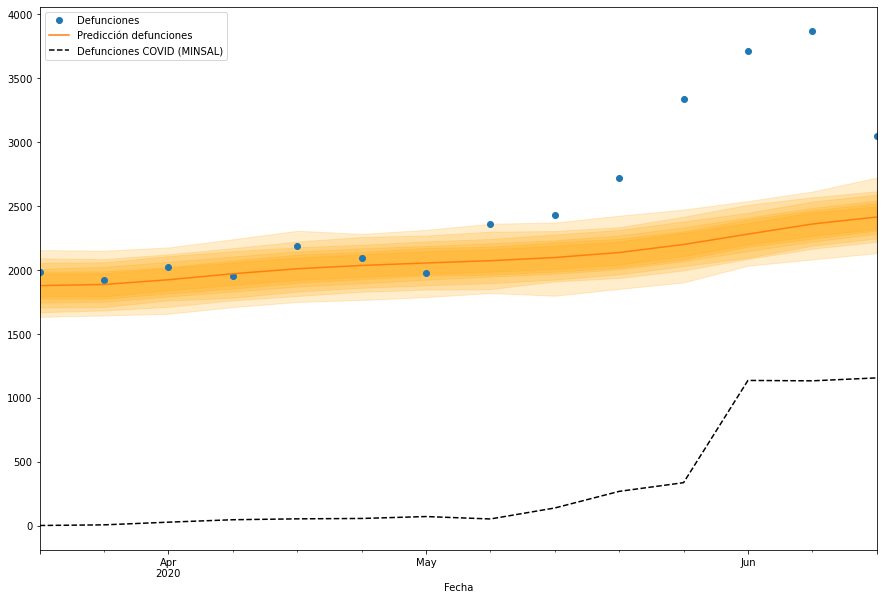

In [13]:
fecha_from_plot = pd.to_datetime('2020-3-22')

df_res = forecast[forecast.Fecha >= fecha_from_plot].set_index('Fecha')

ax = (df_res
      .defunciones.plot(figsize=(15, 10), label='Defunciones', style='o'))

(df_res
 .defunciones_predict.plot(ax=ax, style='-', label='Predicción defunciones'))

for confidence in confidence_list:
    ax.fill_between(df_res.index, 
                 df_res[f'defunciones_predict_lower_{confidence}'], 
                 df_res[f'defunciones_predict_upper_{confidence}'], 
                 color='orange',
                 alpha=0.2, label=None)

muertes_covid.set_index("Fecha").defunciones_covid.plot(ax=ax,
                                                        color='black', 
                                                        style="--", 
                                                        label='Defunciones COVID (MINSAL)')
ax.legend()

In [14]:
fecha_from_covid = pd.to_datetime('2020-3-22')


df_res = forecast[forecast.Fecha >= fecha_from_covid].set_index('Fecha')
muertes_extra = df_res.cumsum().defunciones.values.reshape(-1, 1) - df_res.cumsum().values[:, 1:]

def rename(x):
    y = x.replace('defunciones_predict', 'muertes_extra')
    if 'lower' in x:
        y = y.replace('lower', 'upper')
    if 'upper' in x:
        y = y.replace('upper', 'lower')
    return y 

muertes_extra = pd.DataFrame(muertes_extra, index=df_res.index, columns=[rename(c) for c in df_res.columns[1:]])

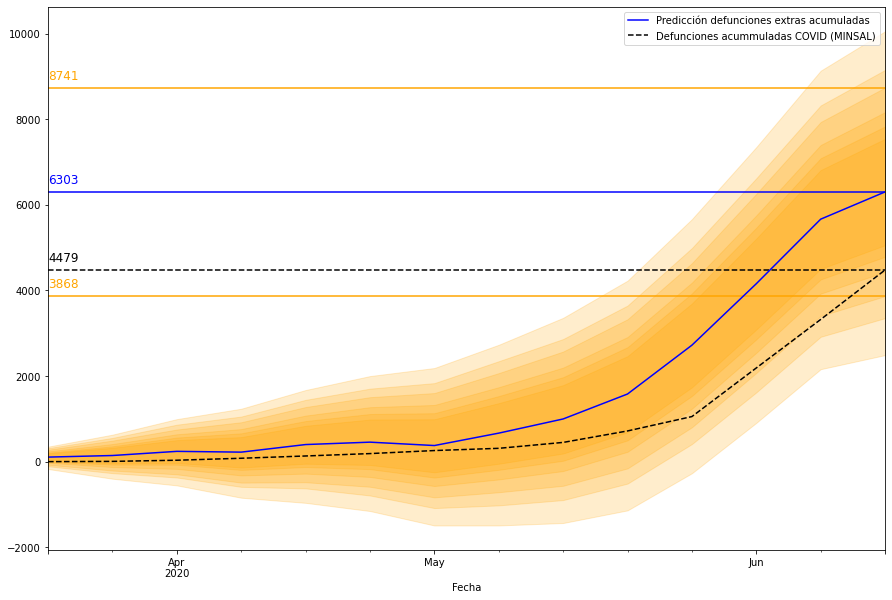

In [33]:
fecha_from_covid = pd.to_datetime('2020-3-22')

ax = (muertes_extra
      .muertes_extra.plot(figsize=(15, 10), 
                          label='Predicción defunciones extras acumuladas', 
                          style='-', color='b'))

ax.hlines(muertes_extra['muertes_extra'].iloc[-1], 
            muertes_extra.index[0], 
            muertes_extra.index[-1],
            linestyle='-', color='b')

ax.text(muertes_extra.index[0], 
          muertes_extra['muertes_extra'].iloc[-1] + 200, 
          int(muertes_extra['muertes_extra'].iloc[-1]), fontsize=12, color='b')


for confidence in confidence_list:
    ax.fill_between(muertes_extra.index, 
                 muertes_extra[f'muertes_extra_lower_{confidence}'], 
                 muertes_extra[f'muertes_extra_upper_{confidence}'], 
                 color='orange',
                 alpha=0.2, label=None)
    
muertes_covid.set_index("Fecha").defunciones_covid_acumuladas.plot(ax=ax,
                                                        color='black', 
                                                        style="--", 
                                                        label='Defunciones acummuladas COVID (MINSAL)')

ax.text(muertes_extra.index[0], 
          muertes_covid['defunciones_covid_acumuladas'].iloc[-1] + 200, 
          muertes_covid['defunciones_covid_acumuladas'].iloc[-1], fontsize=12)

ax.hlines(muertes_covid['defunciones_covid_acumuladas'].iloc[-1], 
            muertes_extra.index[0], 
            muertes_extra.index[-1],
            linestyle='--')


ax.text(muertes_extra.index[0], 
          muertes_extra[f'muertes_extra_lower_{0.9}'].iloc[-1] + 200, 
          muertes_extra[f'muertes_extra_lower_{0.9}'].iloc[-1], fontsize=12, color='orange')

ax.hlines(muertes_extra[f'muertes_extra_lower_{0.9}'].iloc[-1], 
            muertes_extra.index[0], 
            muertes_extra.index[-1],
            linestyle='-', alpha=1, color='orange')

ax.text(muertes_extra.index[0], 
          muertes_extra[f'muertes_extra_upper_{0.9}'].iloc[-1] + 200, 
          muertes_extra[f'muertes_extra_upper_{0.9}'].iloc[-1], fontsize=12, color='orange')

ax.hlines(muertes_extra[f'muertes_extra_upper_{0.9}'].iloc[-1], 
            muertes_extra.index[0], 
            muertes_extra.index[-1],
            linestyle='-', alpha=1, color='orange')


ax.legend()

In [18]:
muertes_extra

,muertes_extra_upper_0.6,muertes_extra_lower_0.6,muertes_extra,muertes_extra_upper_0.7,muertes_extra_lower_0.7,muertes_extra_upper_0.8,muertes_extra_lower_0.8,muertes_extra_upper_0.9,muertes_extra_lower_0.9,muertes_extra_upper_0.95,muertes_extra_lower_0.95,muertes_extra_upper_0.99,muertes_extra_lower_0.99
Fecha,,,,,,,,,,,,,
2020-03-22,193,14,107,210,-3,240,-24,279,-71,315,-107,351,-171
2020-03-29,324,-36,144,359,-69,412,-125,492,-207,555,-268,631,-398
2020-04-05,503,-31,241,563,-71,640,-168,751,-295,864,-370,994,-554
2020-04-12,574,-136,223,662,-192,761,-321,921,-489,1054,-588,1237,-842
2020-04-19,838,-47,400,949,-125,1077,-279,1276,-480,1444,-624,1674,-962
2020-04-26,984,-77,456,1113,-174,1273,-357,1507,-586,1706,-790,2000,-1153
2020-05-03,991,-248,377,1132,-371,1325,-569,1603,-834,1835,-1084,2188,-1491
2020-05-10,1367,-48,667,1532,-190,1740,-415,2069,-714,2347,-1021,2731,-1490
2020-05-17,1788,191,998,1974,22,2198,-219,2573,-563,2865,-897,3361,-1433


In [ ]:
muertes_extra.reset_index().rename(columns=lambda x: x.replace('.', '')).to_gbq('tmp.muertes_extra', project_id=PID, if_exists='replace')
forecast.rename(columns=lambda x: x.replace('.', '')).to_gbq('tmp.forecast', project_id=PID, if_exists='replace')